# Global K-S tests

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import kstest, ks_2samp
import cartopy.crs as ccrs
import numpy as np
#from statsmodels.sandbox.distributions.gof_new import ks_2samp

from jetstream.post_proc import SingleModelPostProcessor

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:44948")
client

Client Scheduler: tcp://127.0.0.1:44948 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 28 Memory: 60.13 GB



### Load anomalies

In [9]:
path = '/project2/moyer/jetstream/era5_processed_data/post_processing_output'

t_prime = xr.open_dataset(f'{path}/era5_1950_1979_t_prime_demeaned.nc4',
                          chunks={'time': 100}
                         )
t_prime = t_prime.where(t_prime.dm_t_prime != 0)

t2m = (
    xr.open_dataset('/project2/moyer/jetstream/era-5-data/subset_data/ds_1950_1979_lat_20_1D_rename.nc',
                    chunks={'time': 100}
                   )
    .rename({'latitude': 'lat', 'longitude': 'lon'})
)
t2m = t2m.where(t2m != 0)
t2m = t2m.assign_coords(lon=(((t2m.lon + 180) % 360) -  180)).sortby('lon')
t2m_demean = SingleModelPostProcessor.demean(t2m.t2m, decade=True)
t2m_demean = t2m_demean.chunk({'time': 100})
t2m_demean

/home/ivanhigueram/.local/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray 't2m' (time: 2555, lat: 280, lon: 1440)>
dask.array<rechunk-merge, shape=(2555, 280, 1440), dtype=float32, chunksize=(100, 280, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-12-01 1950-12-02 ... 1978-03-01
  * lat      (lat) float32 90.0 89.75 89.5 89.25 89.0 ... 21.0 20.75 20.5 20.25
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

## Run KS for anomalies

In [10]:
def ks_test_wrapper(arr_1, arr_2):
    stat = ks_2samp(arr_1,
                    arr_2)
    return stat.pvalue

In [11]:
def plot_decade_ks_test(arr_1,
                        arr_2,
                        start_dates,
                        centered=False
                       ):
    
    for year in start_dates:
        with dask.config.set(**{'array.slicing.split_large_chunks': True}):
            start_year = str(year)
            end_year = str(year + 10)
            print(f'Calculating KS Test from {start_year} to {end_year}')

            # Subset arrays
            print(f'Compute array 1')
            arr_1_subs = (
                arr_1
                .dm_t_prime
                .stack(grid=('lat', 'lon'))
                .sel(time=slice(start_year, end_year))
            )
            
            arr_1_subs = arr_1_subs.where(arr_1_subs != 0, drop=True)           

            print(f'Compute array 2')
            arr_2_subs = (
                arr_2
                .stack(grid=('lat', 'lon'))
                .sel(time=slice(start_year, end_year))
                .sel(time=[t for t in arr_2.time.values if t in arr_1_subs.time.values])
            )
            
            if centered:
                arr_1_subs_mean = arr_1_subs.groupby('time.dayofyear').mean('time')
                arr_1_subs = arr_1_subs - arr_1_subs_mean
                arr_2_subs_mean = arr_2_subs.groupby('time.dayofyear').mean('time')
                arr_2_subs = arr_2_subs - arr_2_subs_mean
       
            # Calculate gridded ks-test
            print(f'Applying ufunc')
            ks_grid = xr.apply_ufunc(
                ks_test_wrapper,
                arr_1_subs.compute(),
                arr_2_subs.compute(),
                input_core_dims=[["time"], ["time"]],
                vectorize=True,
                #dask="parallelized",
                #dask_gufunc_kwargs={'allow_rechunk': True}
            ).unstack('grid')
            
            # Plotting
            print(f'Applying plot function')
            fig = plt.subplots(figsize=(15, 15), facecolor='white')
            ax = plt.axes(projection=ccrs.Orthographic(20,90))

            p = (ks_grid
                 .squeeze()
                 .where(ks_grid <= 0.1)
                 .plot
                 .pcolormesh(
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                     extend='neither',
                     #vmin=0,
                     #vmax=0.1,
                     cbar_kwargs={'orientation': 'horizontal',
                                  'pad': 0.05,
                                  'shrink': 0.7,
                                  'spacing': 'proportional',
                                  'label': 'K-S Test - p-value'
                                 }
                 )
                )
            
            if centered:
                plt.title(
                    (f'P-value from KS Test Demean Temperature and T-prime demeaned anomaly  - Centered\n'
                     f'Only p-values under 10% significance ({start_year} - {end_year}) \n'
                    )
                )
                filename = f'ks_test_{start_year}_centered_decade.png'

            else:
                plt.title(
                    (f'P-value from KS Test Demean Temperature and T-prime demeaned anomaly \n'
                     f'Only p-values under 10% significance ({start_year} - {end_year}) \n'
                    )

                )
                filename = f'ks_test_{start_year}_decade.png'
            p.axes.set_global()
            p.axes.coastlines()
            plt.savefig(filename)

    return ks_grid
    

In [ ]:
years = [year for year in range(1950, 1980) if year%10==0]
ks_grid = plot_decade_ks_test(t_prime,
                              t2m_demean,
                              years,
                              centered=False
                             )

Calculating KS Test from 1950 to 1960
Compute array 1
Compute array 2
Applying ufunc
Applying plot function
Calculating KS Test from 1960 to 1970
Compute array 1
Compute array 2
Applying ufunc
Applying plot function
Calculating KS Test from 1970 to 1980
Compute array 1
Compute array 2
Applying ufunc


### Run KS for centered anomalies

In [67]:
t_prime_mean = t_prime.groupby('time.dayofyear').mean()
t_prime_center = t_prime - t_prime_mean
t_prime_center

t2m_demean_mean = t2m_demean.groupby('time.dayofyear').mean()
t2m_demean_center = t2m_demean - t2m_demean_mean
t2m_demean_center

ks_grid = plot_decade_ks_test(t_prime_center,
                              t2m_demean_center,
                              years,
                              centered=False
                             )

/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/dask/array/core.py:4248: PerformanceWarning: Increasing number of chunks by factor of 91
  **blockwise_kwargs,
/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/dask/array/core.py:4248: PerformanceWarning: Increasing number of chunks by factor of 92
  **blockwise_kwargs,


Calculating KS Test from 1980 to 1990
Compute array 1


KilledWorker: ("('getitem-reshape-transpose-ne-413aaaeaf90caa02095e53419e327c7b', 765, 77, 0)", <Worker 'tcp://127.0.0.1:45608', name: 3, memory: 0, processing: 33560>)

In [34]:
t_prime_grid = (
    t_prime
    .dm_t_prime
    .stack(grid=('lat', 'lon'))
    .sel(time=slice('1990', '2000'))
).compute()

t_grid = (
    t2m_demean
    .stack(grid=('lat', 'lon'))
    .sel(time=slice('1990', '2000'))
    .sel(time=[t for t in t2m_demean.time.values if t in t_prime_grid.time.values])
).compute()

In [35]:
ks_grid = xr.apply_ufunc(
    ks_test_wrapper,
    t_grid,
    t_prime_grid,
    input_core_dims=[["time"], ["time"]],
    vectorize=True
).unstack('grid')

ks_grid

<xarray.DataArray (lat: 280, lon: 1440)>
array([[0.39654507, 0.39654507, 0.39654507, ..., 0.39654507, 0.39654507,
        0.39654507],
       [0.36372949, 0.36372949, 0.36372949, ..., 0.36372949, 0.36372949,
        0.36372949],
       [0.11863941, 0.11863941, 0.11863941, ..., 0.11863941, 0.11863941,
        0.11863941],
       ...,
       [0.43109004, 0.50489924, 0.54380946, ..., 0.46725847, 0.50489924,
        0.50489924],
       [0.66522909, 0.62433184, 0.58372834, ..., 0.62433184, 0.58372834,
        0.66522909],
       [0.95784695, 0.85607662, 0.82168609, ..., 0.95784695, 0.98379543,
        0.97284195]])
Coordinates:
    expver   int32 1
  * lat      (lat) float64 90.0 89.75 89.5 89.25 89.0 ... 21.0 20.75 20.5 20.25
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

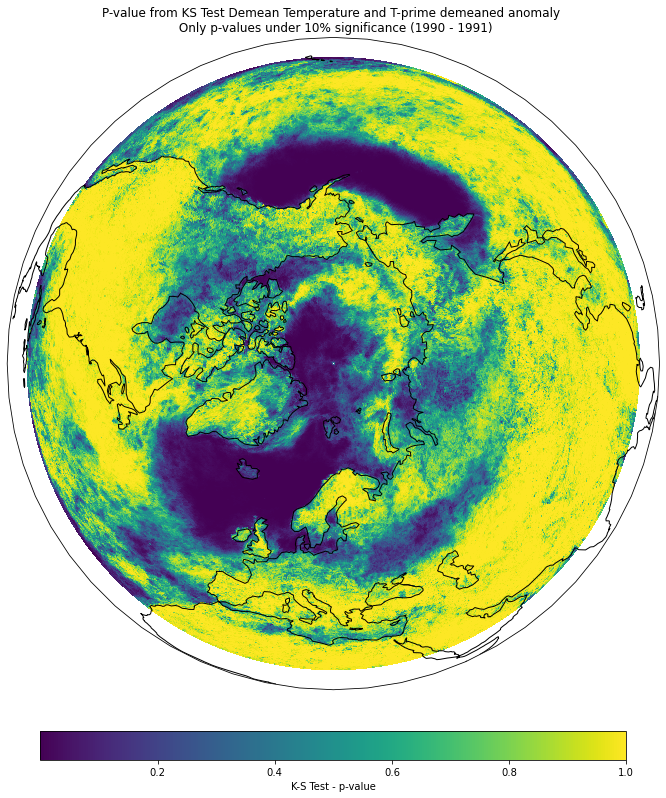

In [37]:


fig = plt.subplots(figsize=(15, 15), facecolor='white')
ax = plt.axes(projection=ccrs.Orthographic(20,90))

p = (ks_grid
     .squeeze()
     #.where(ks_grid < 0.0001)
     .plot
     .pcolormesh(
         ax=ax,
         transform=ccrs.PlateCarree(),
         extend='neither',
         cbar_kwargs={'orientation': 'horizontal',
                      'pad': 0.05,
                      'shrink': 0.7,
                      'spacing': 'proportional',
                      'label': 'K-S Test - p-value'
                     }
     )
    )
plt.title('P-value from KS Test Demean Temperature and T-prime demeaned anomaly \n Only p-values under 10% significance (1990 - 1991)')
p.axes.set_global()
p.axes.coastlines()
plt.savefig('ks_test_90_decade.png')

### Histograms for testing

In [19]:
import pandas as pd
import seaborn as sns

t_prime_grid_test = (
    t_prime_grid
    .unstack('grid')
    .sel(lat=42, lon=-87.5)
    .to_dataframe()
    .reset_index()
)

t_grid_test = (
    t_grid
    .unstack('grid')
    .sel(lat=42, lon=-87.5)
    .to_dataframe()
    .reset_index()
)

t_merge = t_prime_grid_test.merge(
    t_grid_test,
    on=['time', 'lat', 'lon', 'expver']
)

In [20]:
t_merge_melt = pd.melt(t_merge,
        id_vars=['time', 'lat', 'lon', 'expver'],
        value_vars=['dm_t_prime', 't2m']
       )
t_merge_melt

,time,lat,lon,expver,variable,value
0,1990-12-01,42.0,-87.5,1,dm_t_prime,0.000000
1,1990-12-02,42.0,-87.5,1,dm_t_prime,0.000000
2,1990-12-03,42.0,-87.5,1,dm_t_prime,0.000000
3,1990-12-04,42.0,-87.5,1,dm_t_prime,0.000000
4,1990-12-05,42.0,-87.5,1,dm_t_prime,0.000000
...,...,...,...,...,...,...
275,2000-12-08,42.0,-87.5,1,t2m,-2.808258
276,2000-12-09,42.0,-87.5,1,t2m,-5.029694
277,2000-12-10,42.0,-87.5,1,t2m,-0.375671
278,2000-12-11,42.0,-87.5,1,t2m,-0.912018


In [21]:
ks_test_wrapper(t_merge['dm_t_prime'], t_merge['t2m'])

9.485886133212383e-17

/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:>

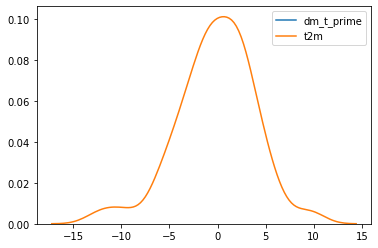

In [22]:
import seaborn as sns 

sns.kdeplot(
    data=t_merge['dm_t_prime'],
    #hue='variable'
)
sns.kdeplot(
    data=t_merge['t2m'],
    #hue='variable'
)

In [209]:
print(t_merge)

          time  expver   lat   lon  dm_t_prime       t2m
0   1990-01-01       1  65.0 -55.0   -4.304434 -3.353760
1   1990-01-02       1  65.0 -55.0   -0.452611  0.060089
2   1990-01-03       1  65.0 -55.0    1.452911  1.377350
3   1990-01-04       1  65.0 -55.0   -1.353503 -1.388916
4   1990-01-05       1  65.0 -55.0    1.373856  0.813049
..         ...     ...   ...   ...         ...       ...
985 2000-12-27       1  65.0 -55.0    6.042930  4.351776
986 2000-12-28       1  65.0 -55.0    4.087522  2.296417
987 2000-12-29       1  65.0 -55.0    3.034480  1.347473
988 2000-12-30       1  65.0 -55.0    2.432885  0.969604
989 2000-12-31       1  65.0 -55.0    0.884534 -0.828400

[990 rows x 6 columns]
